# P10 - Réalisez une application de recommandation de contenu

In [23]:
# Parameters
metadata_path = "../data/deps/articles_metadata.csv"
embeddings_path = "../data/deps/articles_embeddings.pickle"
clicks_path = "../data/deps/clicks_sample.csv"

collaborative_model_path = "../data/outs/model/collaborative_filtering_svd.pkl"
content_based_model_path = "../data/outs/model/content_based_model.pkl"

# 📁 Compréhension des données

### articles_metadata.csv
| Colonne           | Description                                                                 |
|-------------------|-----------------------------------------------------------------------------|
| `article_id`      | 🆔 Identifiant unique de l’article                                           |
| `category_id`     | 🏷️ Catégorie de l’article (ex : sport, économie, etc.)                      |
| `created_at_ts`   | 🕒 Date de création de l’article (timestamp en millisecondes)               |
| `publisher_id`    | 🏢 Identifiant du média ou de l’éditeur                                      |
| `words_count`     | 📏 Nombre de mots dans l’article (utile pour estimer la longueur)           |

###
| Colonne               | Description                                                                 |
|-----------------------|-----------------------------------------------------------------------------|
| `user_id`             | 👤 Identifiant de l’utilisateur                                              |
| `session_id`          | 🔁 Identifiant de la session de navigation                                   |
| `session_start`       | 🕓 Heure de début de session (timestamp)                                    |
| `session_size`        | 🔢 Nombre total de clics dans cette session                                 |
| `click_article_id`    | 📰 ID de l’article cliqué (correspond à `article_id` dans `metadata`)       |
| `click_timestamp`     | ⏱️ Timestamp du moment du clic                                               |
| `click_environment`   | 🌐 Environnement du clic (web, app, mobile...)                               |
| `click_deviceGroup`   | 📱 Type d’appareil utilisé (mobile, desktop, etc.)                           |
| `click_os`            | 💻 Système d’exploitation utilisé (Windows, Android, etc.)                  |
| `click_country`       | 🌍 Pays du clic (identifiant numérique)                                     |
| `click_region`        | 🗺️ Région géographique (identifiant numérique)                              |
| `click_referrer_type` | 🔗 Type de source d’origine du clic (ex : lien externe, article interne...) |

In [24]:
import pandas as pd

metadata = pd.read_csv(metadata_path)

print("- Aperçu rapide des metadatas :")
# Aperçu rapide
metadata.head()

- Aperçu rapide des metadatas :


,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


In [25]:
# Affichage du nombre de lignes (donc d'articles)
print("- Nombre total d’articles (rows) :", metadata.shape[0])

# Vérification unicité
print("- Nombre d’articles uniques (article_id) :", metadata['article_id'].nunique())

- Nombre total d’articles (rows) : 364047
- Nombre d’articles uniques (article_id) : 364047


In [26]:
# 🔍 Compter les articles par catégorie
category_counts = metadata['category_id'].value_counts().sort_index()

category_counts

category_id
0         1
1      4418
2       861
3         9
4       128
       ... 
456      23
457       3
458     673
459       4
460      25
Name: count, Length: 461, dtype: int64

In [27]:
import pandas as pd

clicks = pd.read_csv(clicks_path)

print("- Aperçu rapide des clics :")
# Aperçu rapide
clicks.head()

- Aperçu rapide des clics :


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


In [28]:
# Affichage du nombre de lignes (donc d'articles)
print("- Nombre total de clics (rows) :", clicks.shape[0])

- Nombre total de clics (rows) : 1883



✅ Correspondance session_size vs réel :
match
True    707
Name: count, dtype: int64

Nombre de sessions uniques : 707


/tmp/ipykernel_6950/4144661684.py:26: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/bruno/miniconda3/envs/p10/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


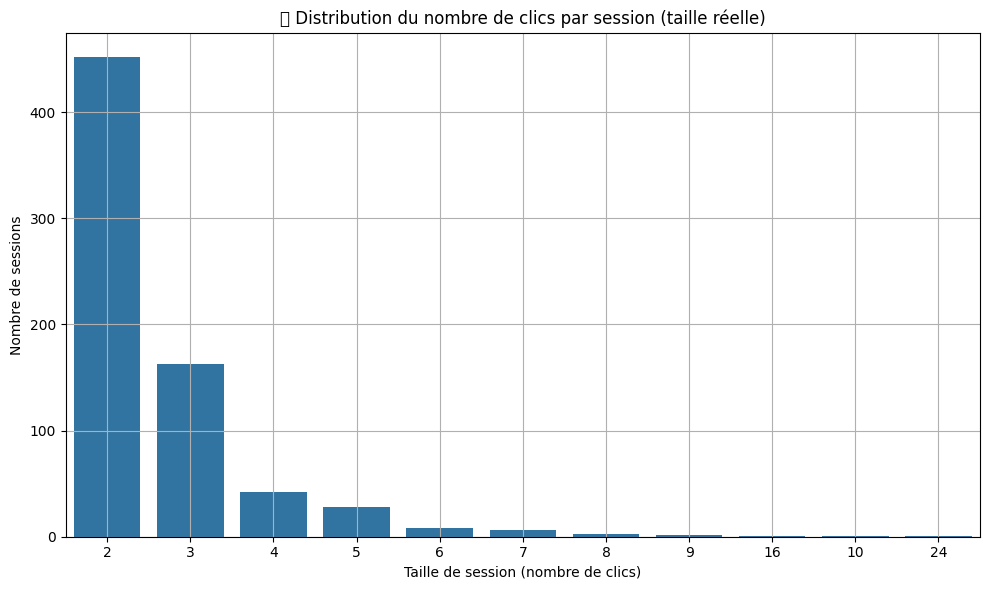

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 🔹 2. Calcul du nombre réel de clics par session_id
real_session_sizes = clicks.groupby("session_id").size().reset_index(name="real_session_size")

# 🔹 3. Comparaison avec la colonne session_size (du fichier)
merged = clicks[["session_id", "session_size"]].drop_duplicates().merge(real_session_sizes, on="session_id")

# 🔹 4. Vérifier s'il y a des incohérences
merged["match"] = merged["session_size"] == merged["real_session_size"]

# 🔍 Afficher les stats
print("\n✅ Correspondance session_size vs réel :")
print(merged["match"].value_counts())
print(f"\nNombre de sessions uniques : {merged.shape[0]}")

# 🔹 5. Distribution des tailles de sessions
plt.figure(figsize=(10,6))
sns.countplot(data=merged, x="real_session_size", order=merged["real_session_size"].value_counts().index)
plt.title("📊 Distribution du nombre de clics par session (taille réelle)")
plt.xlabel("Taille de session (nombre de clics)")
plt.ylabel("Nombre de sessions")
plt.grid(True)
plt.tight_layout()
plt.show()

- 🟦 La majorité des sessions ont exactement 2 clics 
- 📉 Il y a quelques sessions plus longues (3, 4, 5...), mais c’est rare
- ❌ Il n’y a presque aucune session avec 1 seul clic, donc pas de rating = 1.0
- ✔️ Ton session_size dans le fichier est parfaitement aligné avec la réalité (le nombre de lignes)

# Étape 1 : Élaboration d’un modèle Content-Based Filtering

/tmp/ipykernel_6950/4074255635.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Catégorie", bbox_to_anchor=(1.05, 1), loc='upper left')


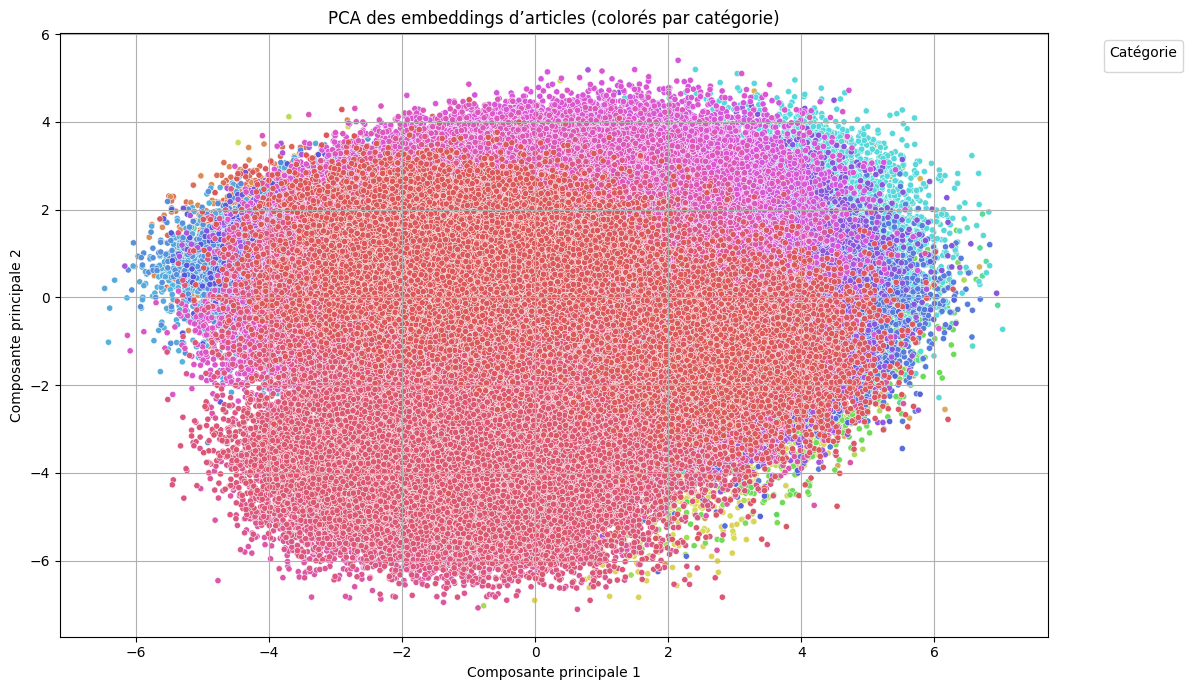

In [30]:
import pandas as pd
import pickle
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# 🔹 1. Charger les embeddings
with open(embeddings_path, "rb") as f:
    embeddings_array = pickle.load(f)

metadata = pd.read_csv(metadata_path)
    
# 🔧 Créer le DataFrame embeddings
embedding_columns = [f"embedding_{i}" for i in range(embeddings_array.shape[1])]
df_embed = pd.DataFrame(embeddings_array, columns=embedding_columns)
df_embed["article_id"] = metadata["article_id"]

# ✅ Merge des catégories
df = pd.merge(df_embed, metadata[["article_id", "category_id"]], on="article_id")

# 🔍 Séparer features et labels
X = df[embedding_columns]
y = df["category_id"]

# 🔹 3. PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

# 🔹 4. Visualisation colorée par catégorie
plt.figure(figsize=(12, 7))
palette = sns.color_palette("hls", len(y.unique()))
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=y, palette=palette, legend=False, s=20)
plt.title("PCA des embeddings d’articles (colorés par catégorie)")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.legend(title="Catégorie", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def recommend_content_based(user_id, clicks_df, embeddings_df, top_k=5):
    """
    Recommande les articles les plus similaires au dernier article cliqué par un utilisateur.
    
    Params :
        user_id : int
        clicks_df : DataFrame avec colonnes ['user_id', 'click_article_id', 'click_timestamp']
        embeddings_df : DataFrame avec colonnes ['article_id', ...embeddings]
        top_k : int, nombre d’articles à recommander

    Retour :
        Liste des top_k article_ids recommandés
    """
    # 🔍 Filtrer les clics de l’utilisateur
    user_clicks = clicks_df[clicks_df["user_id"] == user_id]
    if user_clicks.empty:
        return []  # Pas de clics connus pour cet utilisateur

    # 🕐 Récupérer le dernier article cliqué
    last_click = user_clicks.sort_values(by="click_timestamp", ascending=False).iloc[0]
    last_article_id = last_click["click_article_id"]

    # 🧠 Embedding de l’article cliqué
    article_embedding = embeddings_df[embeddings_df["article_id"] == last_article_id]
    if article_embedding.empty:
        return []

    base_vector = article_embedding.drop(columns=["article_id"]).values

    # 🎯 Embeddings des autres articles
    all_embeddings = embeddings_df.drop(columns=["article_id"]).values
    all_article_ids = embeddings_df["article_id"].values

    # 🔁 Calcul de la similarité cosinus
    similarities = cosine_similarity(base_vector, all_embeddings)[0]

    # 🧹 Exclure les articles déjà lus
    already_clicked_ids = user_clicks["click_article_id"].unique()
    candidates = [(aid, score) for aid, score in zip(all_article_ids, similarities) if aid not in already_clicked_ids]

    # 🔝 Trier et prendre les top_k
    top_articles = sorted(candidates, key=lambda x: x[1], reverse=True)[:top_k]

    return [int(article_id) for article_id, _ in top_articles]


In [32]:
# clicks_df = pd.read_csv("clicks_sample.csv")
# embeddings_df = df_embed (déjà préparé avec article_id + embeddings)

user_id = 0
reco = recommend_content_based(user_id, clicks, df_embed)
print(f"🔁 Recommandations Content-Based pour user {user_id} : {reco}")

🔁 Recommandations Content-Based pour user 0 : [358037, 159170, 65360, 152054, 153876]


In [33]:
import pickle
import os

os.makedirs(os.path.dirname(content_based_model_path), exist_ok=True)

# 📦 Objet à sauvegarder
content_model = {
    "embeddings": df_embed  # DataFrame contenant article_id + embeddings
}

# 💾 Sauvegarde en pickle
with open(content_based_model_path, "wb") as f:
    pickle.dump(content_model, f)

print(f"✅ Modèle Content-Based sauvegardé dans : {content_based_model_path}")

✅ Modèle Content-Based sauvegardé dans : ../data/outs/model/content_based_model.pkl


# 🧩 Étape 2 : Approche collaborative par facteurs latents

On part d’un système basé sur les clics, on déduit un rating explicite, et ensuite on applique SVD réduite pour prédire les notes manquantes

### Rating Implicite

  $$
  \text{rating} = \frac{\text{click\_count}}{\text{session\_size}}
  $$

In [49]:
import numpy as np
import pandas as pd

def load_data_fixed(filepath=clicks_path, add_negatives=False, n_negative_per_user=5):
    df = pd.read_csv(filepath)

    # Positifs = clics
    df["rating"] = 1
    positive = df[["user_id", "click_article_id", "rating"]]

    if not add_negatives:
        return positive

    # Ajout de négatifs simulés
    all_users = df["user_id"].unique()
    all_items = df["click_article_id"].unique()
    negatives = []

    for user in all_users:
        clicked = set(df[df["user_id"] == user]["click_article_id"])
        not_clicked = list(set(all_items) - clicked)
        sampled = np.random.choice(not_clicked, size=min(n_negative_per_user, len(not_clicked)), replace=False)
        for item in sampled:
            negatives.append([user, item, 0])

    df_neg = pd.DataFrame(negatives, columns=["user_id", "click_article_id", "rating"])
    df_all = pd.concat([positive, df_neg], ignore_index=True)
    return df_all


def load_data_weighted(filepath=clicks_path, normalize=True, add_negatives=False, n_negative_per_user=5):
    df = pd.read_csv(filepath)

    # Calcul du rating implicite : clics / session_size
    df_grouped = df.groupby(["user_id", "click_article_id", "session_id", "session_size"]) \
                   .size().reset_index(name="click_count")
    df_grouped["rating"] = df_grouped["click_count"] / df_grouped["session_size"]

    # Normalisation facultative
    if normalize:
        max_rating = df_grouped["rating"].max()
        if max_rating > 0:
            df_grouped["rating"] = df_grouped["rating"] / max_rating
            df_grouped["rating"] = df_grouped["rating"].clip(upper=1.0)

    positive = df_grouped[["user_id", "click_article_id", "rating"]]

    if not add_negatives:
        return positive

    # Ajout de négatifs
    all_users = df["user_id"].unique()
    all_items = df["click_article_id"].unique()
    negatives = []

    for user in all_users:
        clicked = set(df_grouped[df_grouped["user_id"] == user]["click_article_id"])
        not_clicked = list(set(all_items) - clicked)
        sampled = np.random.choice(not_clicked, size=min(n_negative_per_user, len(not_clicked)), replace=False)
        for item in sampled:
            negatives.append([user, item, 0])

    df_neg = pd.DataFrame(negatives, columns=["user_id", "click_article_id", "rating"])
    df_all = pd.concat([positive, df_neg], ignore_index=True)
    return df_all


### histogramme de TOUS les rating calculés pour chaque clic utilisateur sur un article, pas une moyenne par article ou par utilisateur.

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# 📊 Visualisation de la distribution des ratings implicites
def plot_rating_distribution(df_ratings, remove_outliers=True, log_scale=False):
    """
    Affiche un histogramme de la distribution des ratings implicites.
    
    Params:
        df_ratings (DataFrame): DataFrame contenant au moins la colonne "rating"
        remove_outliers (bool): Supprime les valeurs extrêmes si True
        log_scale (bool): Affiche l'axe X en échelle logarithmique si True
    """
    ratings = df_ratings["rating"].copy()

    # 🧹 Suppression des outliers extrêmes (au-dessus du 99e percentile)
    if remove_outliers:
        upper_limit = ratings.quantile(0.99)
        ratings = ratings[ratings <= upper_limit]

    plt.figure(figsize=(10,6))
    sns.histplot(ratings, bins=50, kde=True)
    
    plt.title("Distribution des Ratings Implicites")
    plt.xlabel("Rating (pondéré clics / session_size)")
    plt.ylabel("Nombre d'occurrences")

    if log_scale:
        plt.xscale("log")
        plt.xlabel("Rating (log scale)")

    plt.grid(True)
    plt.tight_layout()
    plt.show()

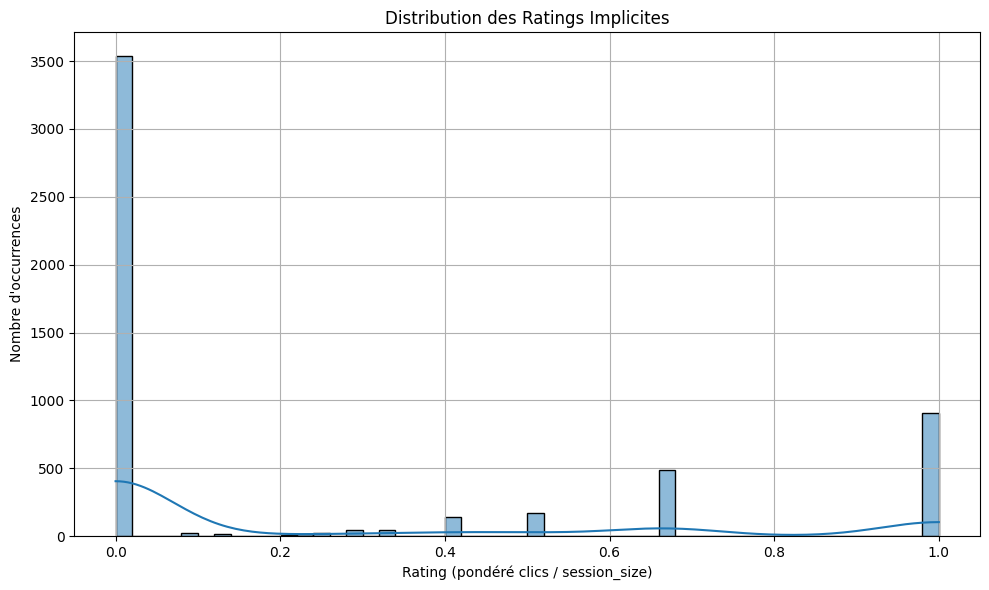

In [58]:
df = load_data_weighted(normalize=True, add_negatives=True)
plot_rating_distribution(df)  # simple


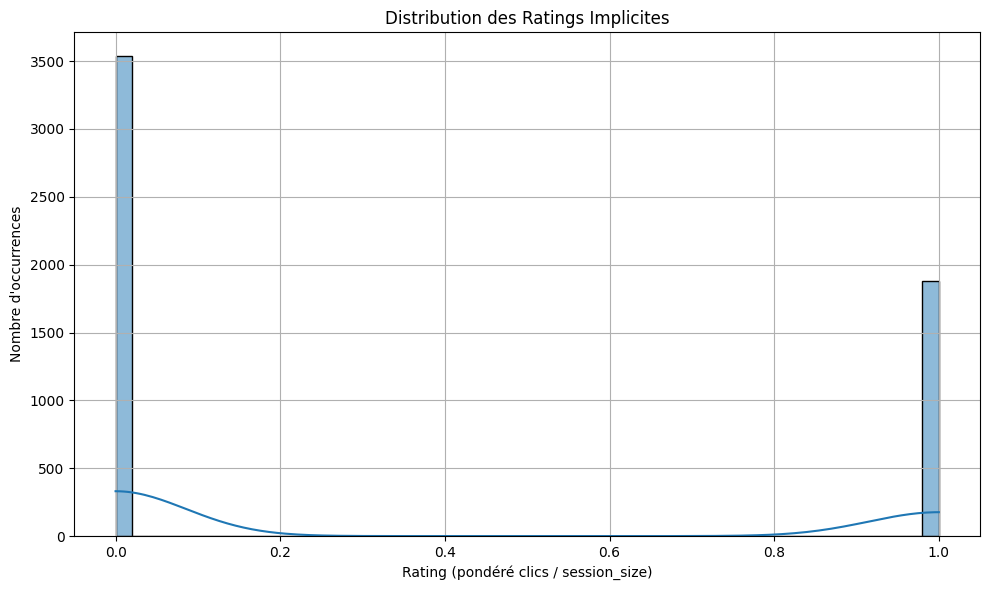

In [52]:
df = load_data_fixed(add_negatives=True)
plot_rating_distribution(df)  # simple

### Entraînement avec SVD

In [70]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_squared_error

# 🔹 Entraînement d’un modèle SVD
def train_model(df, n_factors=100):
    reader = Reader(rating_scale=(0, 1))
    data = Dataset.load_from_df(df, reader)
    trainset = data.build_full_trainset()
    model = SVD(n_factors=n_factors)
    model.fit(trainset)
    return model, trainset

# 🔹 Recommandation top-N articles pour un utilisateur
def get_top_5(user_id, model, trainset, n=5):
    all_article_ids = trainset._raw2inner_id_items.keys()
    read_articles = set([j for (j, _) in trainset.ur[trainset.to_inner_uid(user_id)]]) \
        if user_id in trainset._raw2inner_id_users else set()
    candidates = [aid for aid in all_article_ids if aid not in read_articles]

    predictions = [(aid, model.predict(user_id, aid).est) for aid in candidates]
    top_n = sorted(predictions, key=lambda x: x[1], reverse=True)[:n]
    return [int(article_id) for article_id, _ in top_n]

# 🔹 Évaluation RMSE pour différents k
def evaluate_model(df, k_list=[10, 20, 50]):
    reader = Reader(rating_scale=(0, 1))
    data = Dataset.load_from_df(df, reader)
    best_k = None
    best_rmse = float("inf")

    print("🔍 Évaluation des dimensions latentes (n_factors):\n")
    for k in k_list:
        model = SVD(n_factors=k)
        results = cross_validate(model, data, measures=["RMSE"], cv=3, verbose=False)
        rmse_mean = results["test_rmse"].mean()
        print(f"➡️ n_factors = {k} → RMSE moyen = {rmse_mean:.4f}")

        if rmse_mean < best_rmse:
            best_rmse = rmse_mean
            best_k = k

    print(f"\n✅ Meilleur k = {best_k} avec RMSE = {best_rmse:.4f}")
    return best_k

# 🔹 Évaluation avec Precision@k, Recall@k, RMSE
def evaluate_precision_recall_rmse(predictions, k_list=[1, 2, 3, 5, 10, 20], threshold=0.5):
    precision_scores = []
    recall_scores = []
    rmse_scores = []

    all_user_preds = defaultdict(list)
    for pred in predictions:
        all_user_preds[pred.uid].append((pred.iid, pred.est, pred.r_ui))

    print("\n📊 Évaluation Precision@k / Recall@k / RMSE :\n")

    for k in k_list:
        precisions, recalls = [], []

        for uid, user_ratings in all_user_preds.items():
            user_ratings.sort(key=lambda x: x[1], reverse=True)
            top_k = user_ratings[:k]

            n_rel = sum((true_r >= threshold) for (_, _, true_r) in user_ratings)
            n_rec_k = sum((est >= threshold) for (_, est, _) in top_k)
            n_rel_and_rec_k = sum((true_r >= threshold and est >= threshold) for (_, est, true_r) in top_k)

            precision = n_rel_and_rec_k / n_rec_k if n_rec_k else 0
            recall = n_rel_and_rec_k / n_rel if n_rel else 0

            precisions.append(precision)
            recalls.append(recall)

        y_true = [pred.r_ui for pred in predictions]
        y_pred = [pred.est for pred in predictions]
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))

        precision_mean = np.mean(precisions)
        recall_mean = np.mean(recalls)

        print(f"➡️ k={k} | Precision@{k} = {precision_mean:.4f} | Recall@{k} = {recall_mean:.4f} | RMSE = {rmse:.4f}")

# 🔹 Création d'un testset avec négatifs simulés
def build_testset_with_negatives(df, n_negatives=20):
    users = df["user_id"].unique()
    items = df["click_article_id"].unique()
    test_data = []

    grouped = df.groupby("user_id")["click_article_id"].apply(set).to_dict()

    for user in users:
        pos_items = grouped.get(user, set())
        test_data.extend([(user, item, 1.0) for item in pos_items])

        neg_candidates = list(set(items) - pos_items)
        sampled_neg = np.random.choice(neg_candidates, size=min(n_negatives, len(neg_candidates)), replace=False)
        test_data.extend([(user, item, 0.0) for item in sampled_neg])

    return test_data

# 🔹 MAIN
if __name__ == "__main__":
    df_fixed = load_data_fixed()
    df_weighted = load_data_weighted()

    print("\n📊 Évaluation modèle FIXE")
    best_k_fixed = evaluate_model(df_fixed, k_list=[1, 2, 3, 4, 5, 10, 50, 100])

    print("\n📊 Évaluation modèle PONDÉRÉ")
    best_k_weighted = evaluate_model(df_weighted, k_list=[1, 2, 3, 4, 5, 10, 50, 100])

    model_fixed, trainset_fixed = train_model(df_fixed, n_factors=best_k_fixed)
    model_weighted, trainset_weighted = train_model(df_weighted, n_factors=best_k_weighted)

    user_id = df_fixed["user_id"].iloc[0]
    recos_fixed = get_top_5(user_id, model_fixed, trainset_fixed)
    recos_weighted = get_top_5(user_id, model_weighted, trainset_weighted)

    print(f"\n📌 Recos FIXE pour user {user_id} : {recos_fixed}")
    print(f"📌 Recos PONDÉRÉES pour user {user_id} : {recos_weighted}")

    # ➤ Évaluation FIXE avec vrais négatifs simulés
    print("\n📈 [Évaluation FIXE avec vrais négatifs simulés]")
    reader = Reader(rating_scale=(0, 1))
    data_fixed = Dataset.load_from_df(df_fixed, reader)
    trainset_f, _ = train_test_split(data_fixed, test_size=0.25, random_state=42)
    model_f = SVD(n_factors=best_k_fixed)
    model_f.fit(trainset_f)
    testset_f_neg = build_testset_with_negatives(df_fixed, n_negatives=20)
    pred_f = model_f.test(testset_f_neg)
    evaluate_precision_recall_rmse(pred_f, threshold=0.85)

    # ➤ Évaluation PONDÉRÉE avec vrais négatifs simulés
    print("\n📈 [Évaluation PONDÉRÉ avec vrais négatifs simulés]")
    data_weighted = Dataset.load_from_df(df_weighted, reader)
    trainset_w, _ = train_test_split(data_weighted, test_size=0.25, random_state=42)
    model_w = SVD(n_factors=best_k_weighted)
    model_w.fit(trainset_w)
    testset_w_neg = build_testset_with_negatives(df_weighted, n_negatives=20)
    pred_w = model_w.test(testset_w_neg)
    evaluate_precision_recall_rmse(pred_w, threshold=0.85)

    # ➤ Sauvegarde modèle pondéré
    os.makedirs(os.path.dirname(collaborative_model_path), exist_ok=True)
    with open(collaborative_model_path, "wb") as f:
        pickle.dump((model_weighted, trainset_weighted), f)


📊 Évaluation modèle FIXE
🔍 Évaluation des dimensions latentes (n_factors):

➡️ n_factors = 1 → RMSE moyen = 0.0058
➡️ n_factors = 2 → RMSE moyen = 0.0074
➡️ n_factors = 3 → RMSE moyen = 0.0087
➡️ n_factors = 4 → RMSE moyen = 0.0103
➡️ n_factors = 5 → RMSE moyen = 0.0124
➡️ n_factors = 10 → RMSE moyen = 0.0177
➡️ n_factors = 50 → RMSE moyen = 0.0378
➡️ n_factors = 100 → RMSE moyen = 0.0509

✅ Meilleur k = 1 avec RMSE = 0.0058

📊 Évaluation modèle PONDÉRÉ
🔍 Évaluation des dimensions latentes (n_factors):

➡️ n_factors = 1 → RMSE moyen = 0.2058
➡️ n_factors = 2 → RMSE moyen = 0.2049
➡️ n_factors = 3 → RMSE moyen = 0.2063
➡️ n_factors = 4 → RMSE moyen = 0.2092
➡️ n_factors = 5 → RMSE moyen = 0.2074
➡️ n_factors = 10 → RMSE moyen = 0.2079
➡️ n_factors = 50 → RMSE moyen = 0.2153
➡️ n_factors = 100 → RMSE moyen = 0.2202

✅ Meilleur k = 2 avec RMSE = 0.2049

📌 Recos FIXE pour user 0 : [157541, 68866, 235840, 30970, 236294]
📌 Recos PONDÉRÉES pour user 0 : [96663, 235840, 108854, 119592, 209723

<Figure size 600x500 with 0 Axes>

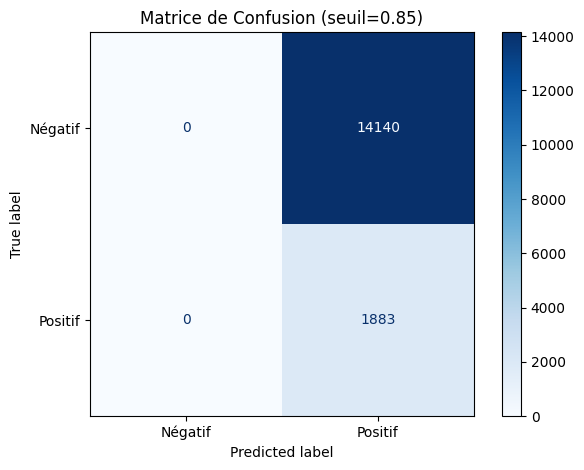

<Figure size 600x500 with 0 Axes>

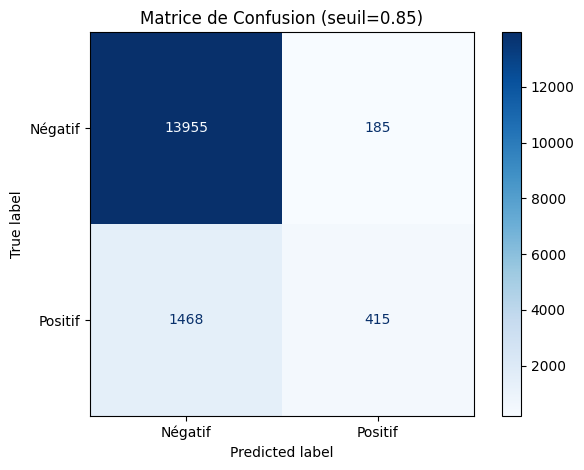

In [73]:
def generate_confusion_matrix(predictions, threshold=0.5):
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

    y_true = np.array([pred.r_ui for pred in predictions])
    y_pred = np.array([pred.est for pred in predictions])

    y_pred_binary = (y_pred >= threshold).astype(int)
    y_true_binary = y_true.astype(int)

    cm = confusion_matrix(y_true_binary, y_pred_binary)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Négatif", "Positif"])
    
    plt.figure(figsize=(6, 5))
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Matrice de Confusion (seuil={threshold})")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

generate_confusion_matrix(pred_f, threshold=0.85)
generate_confusion_matrix(pred_w, threshold=0.85)


/tmp/ipykernel_6950/3391237319.py:46: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/bruno/miniconda3/envs/p10/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


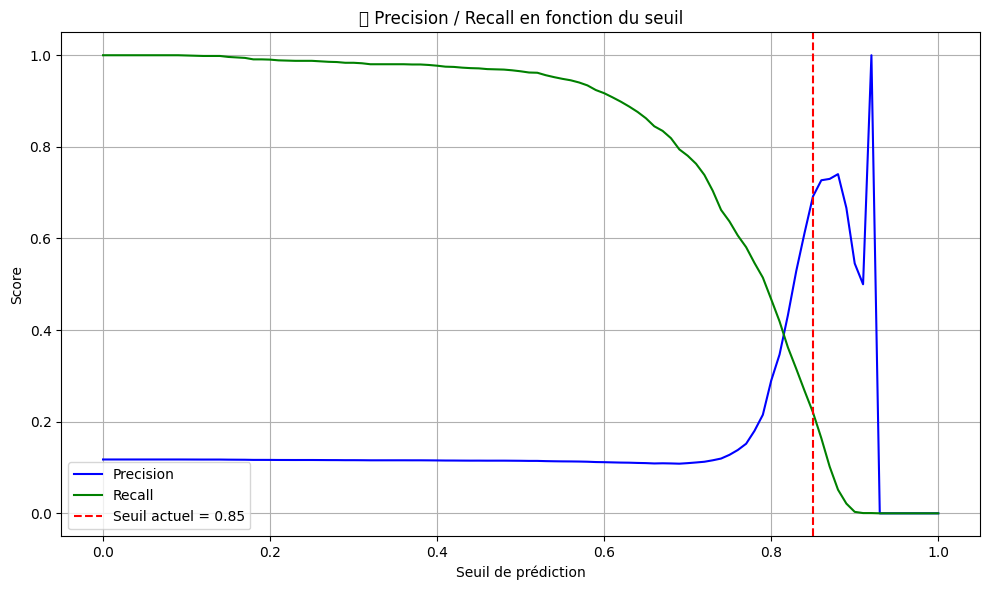

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

def compute_precision_recall_over_thresholds(predictions, thresholds):
    y_true = np.array([pred.r_ui for pred in predictions])
    y_pred = np.array([pred.est for pred in predictions])

    precisions = []
    recalls = []

    for thresh in thresholds:
        y_pred_bin = (y_pred >= thresh).astype(int)
        y_true_bin = y_true.astype(int)

        precision = precision_score(y_true_bin, y_pred_bin, zero_division=0)
        recall = recall_score(y_true_bin, y_pred_bin, zero_division=0)

        precisions.append(precision)
        recalls.append(recall)

    return precisions, recalls

# Définir les seuils de test
thresholds = np.linspace(0.0, 1.0, 101)

# Utiliser les prédictions `pred_w` si elles existent (sinon simulation minimale)
if 'pred_w' in globals():
    predictions = pred_w
else:
    from types import SimpleNamespace
    predictions = [SimpleNamespace(r_ui=r, est=e) for r, e in zip([1, 0, 1, 0], [0.9, 0.8, 0.4, 0.7])]

precisions, recalls = compute_precision_recall_over_thresholds(predictions, thresholds)

# Tracer la courbe
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision", color="blue")
plt.plot(thresholds, recalls, label="Recall", color="green")
plt.axvline(x=0.85, color="red", linestyle="--", label="Seuil actuel = 0.85")
plt.xlabel("Seuil de prédiction")
plt.ylabel("Score")
plt.title("🎯 Precision / Recall en fonction du seuil")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipykernel_6950/4165444496.py:17: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/bruno/miniconda3/envs/p10/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


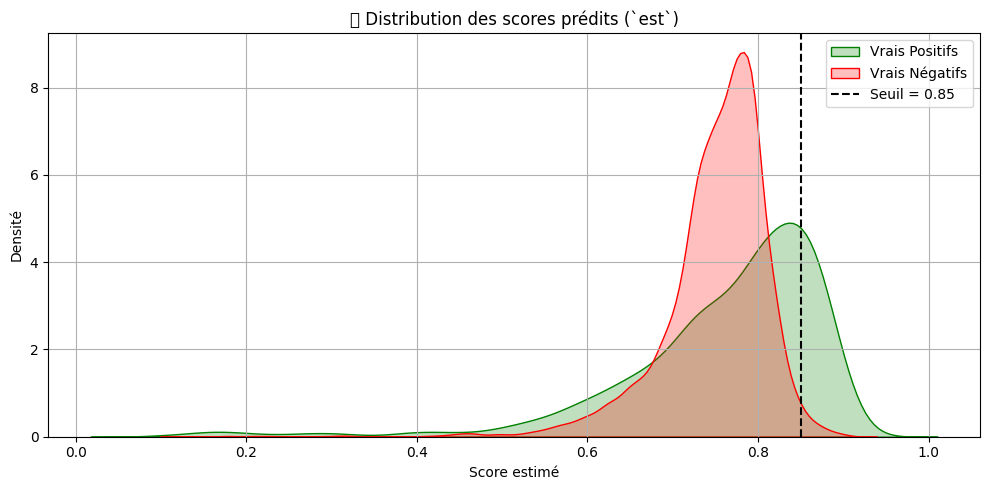

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_prediction_distribution(predictions):
    est_pos = [pred.est for pred in predictions if pred.r_ui == 1.0]
    est_neg = [pred.est for pred in predictions if pred.r_ui == 0.0]

    plt.figure(figsize=(10, 5))
    sns.kdeplot(est_pos, label="Vrais Positifs", fill=True, color="green")
    sns.kdeplot(est_neg, label="Vrais Négatifs", fill=True, color="red")
    plt.axvline(x=0.85, linestyle="--", color="black", label="Seuil = 0.85")
    plt.title("📈 Distribution des scores prédits (`est`)")
    plt.xlabel("Score estimé")
    plt.ylabel("Densité")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_prediction_distribution(pred_w) 

/tmp/ipykernel_6950/1844861103.py:29: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/bruno/miniconda3/envs/p10/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


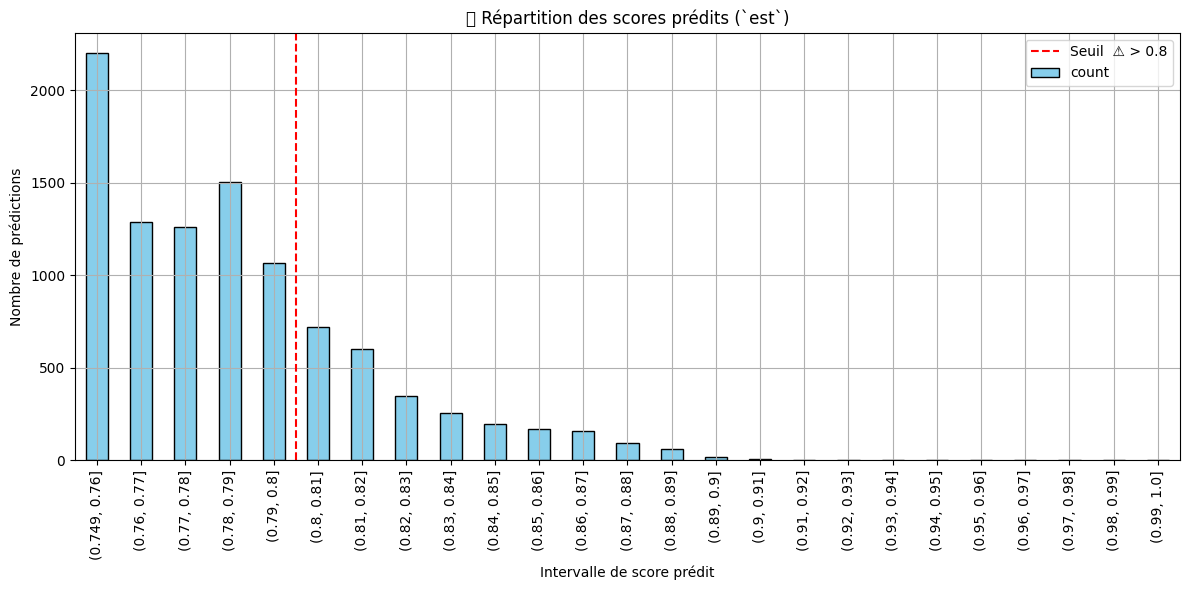

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_prediction_bins(predictions, bin_edges=None, seuil_attention=0.85):
    """
    Affiche un histogramme des scores prédits arrondis (par pas).
    """
    # Par défaut : on découpe les prédictions de 0.0 à 1.0 par pas de 0.01
    if bin_edges is None:
        bin_edges = [round(i/100, 2) for i in range(0, 101)]

    scores = [round(pred.est, 2) for pred in predictions]
    df = pd.DataFrame(scores, columns=["score"])

    # Compter les occurrences par bin
    df["bin"] = pd.cut(df["score"], bins=bin_edges, include_lowest=True)
    counts = df["bin"].value_counts().sort_index()

    # Tracer
    plt.figure(figsize=(12, 6))
    counts.plot(kind="bar", color="skyblue", edgecolor="black")
    plt.axvline(x=bin_edges.index(seuil_attention/1.0) - 0.5, color="red", linestyle="--", label=f"Seuil  ⚠️ > {seuil_attention}")
    plt.title("📊 Répartition des scores prédits (`est`)")
    plt.xlabel("Intervalle de score prédit")
    plt.ylabel("Nombre de prédictions")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

bins = [round(i/100, 2) for i in range(75, 101)]  # 0.80 à 1.00
plot_prediction_bins(pred_w, bin_edges=bins, seuil_attention=0.8)

/tmp/ipykernel_6950/2458011931.py:52: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/bruno/miniconda3/envs/p10/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


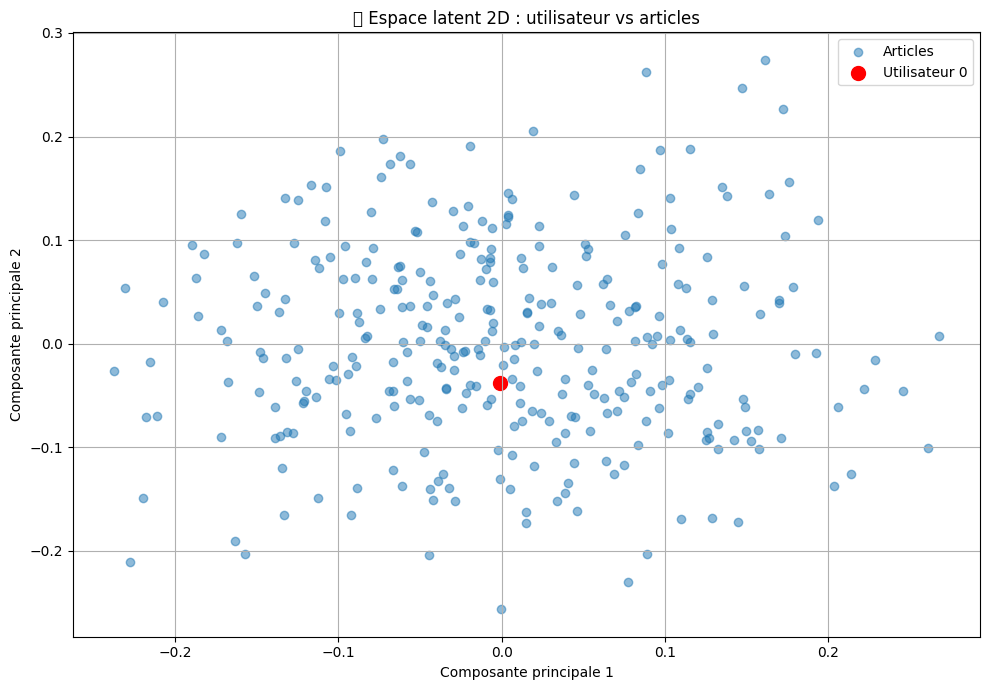

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_user_vs_items_in_latent_space(model, trainset, user_id):
    """
    Affiche la position 2D (via PCA) du vecteur utilisateur vs les articles (items) dans l'espace latent.
    
    Args:
        model: modèle SVD entraîné
        trainset: trainset Surprise utilisé pour l'entraînement
        user_id: ID externe de l'utilisateur à visualiser
    """
    # 🔸 Vérifier que l'utilisateur est connu
    if user_id not in trainset._raw2inner_id_users:
        print(f"❌ Utilisateur {user_id} inconnu dans le trainset.")
        return

    # 🔹 1. Vecteur utilisateur
    user_inner_id = trainset.to_inner_uid(user_id)
    user_vec = model.pu[user_inner_id]  # vecteur latent (dim k)

    # 🔹 2. Vecteurs des articles
    item_vecs = model.qi  # matrice (nb_items x k)

    # 🔹 3. PCA uniquement si au moins 2 vecteurs
    all_vecs = np.vstack([user_vec] + list(item_vecs))

    if all_vecs.shape[0] < 2:
        print(f"❌ PCA impossible : seulement {all_vecs.shape[0]} vecteur(s) disponibles.")
        return

    if all_vecs.shape[1] < 2:
        print(f"❌ PCA impossible : vecteurs de dimension {all_vecs.shape[1]} (besoin ≥ 2).")
        return

    pca = PCA(n_components=2)
    all_vecs_2d = pca.fit_transform(all_vecs)

    user_2d = all_vecs_2d[0]
    items_2d = all_vecs_2d[1:]

    # 🔹 4. Affichage
    plt.figure(figsize=(10, 7))
    plt.scatter(items_2d[:, 0], items_2d[:, 1], alpha=0.5, label="Articles")
    plt.scatter(user_2d[0], user_2d[1], color='red', s=100, label=f"Utilisateur {user_id}")
    plt.title("📊 Espace latent 2D : utilisateur vs articles")
    plt.xlabel("Composante principale 1")
    plt.ylabel("Composante principale 2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Sélection d’un utilisateur connu dans les données pondérées
user_id = df_weighted["user_id"].iloc[0]

# Appel de la fonction de visualisation
plot_user_vs_items_in_latent_space(model_weighted, trainset_weighted, user_id)


## Testing

## Curl

```bash
    curl -X POST http://localhost:7071/api/recommend-articles-collaborative \
      -H "Content-Type: application/json" \
      -d '{"user_id": 501}'
```